<a href="https://colab.research.google.com/github/tsengcc2023/Financial-Big-Data-Analysis/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 作業1：使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。
輸出結果範例： 輸入20天收盤價，預測隔一天收盤價

## 資料下載與處理

In [1]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# 下載台積電股票數據
stock_code = "2330.TW"
start_date = "2024-01-01"
end_date = "2024-10-31"
data = yf.download(stock_code, start=start_date, end=end_date)

# 只取收盤價並縮放數據
data = data[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

[*********************100%***********************]  1 of 1 completed


## 構建資料集

In [2]:
# 設定窗口大小
window_size = 20

# 創建訓練和測試集
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size - window_size:]

# 將數據分割成輸入和標籤
def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Reshape資料以適應LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## 建立 LSTM 模型

In [3]:
# 建立模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - loss: 0.3671 - val_loss: 0.2809
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0755 - val_loss: 0.0083
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0272 - val_loss: 0.0139
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0160 - val_loss: 0.0261
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0121 - val_loss: 0.0414
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0138 - val_loss: 0.0192
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0087 - val_loss: 0.0063
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0083 - val_loss: 0.0070
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0063 - val_loss: 0.0133
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0067 - val_loss: 0.0146
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0073 - val_loss: 0.0084
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0063 - val_loss: 0.0076


## 預測與反向縮放

In [4]:
# 預測股價
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向縮放
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [7]:
# 確保 test_predict 的形狀為一維陣列，並且與 test_dates 長度相符
test_predict = test_predict[:len(test_dates)].reshape(-1)

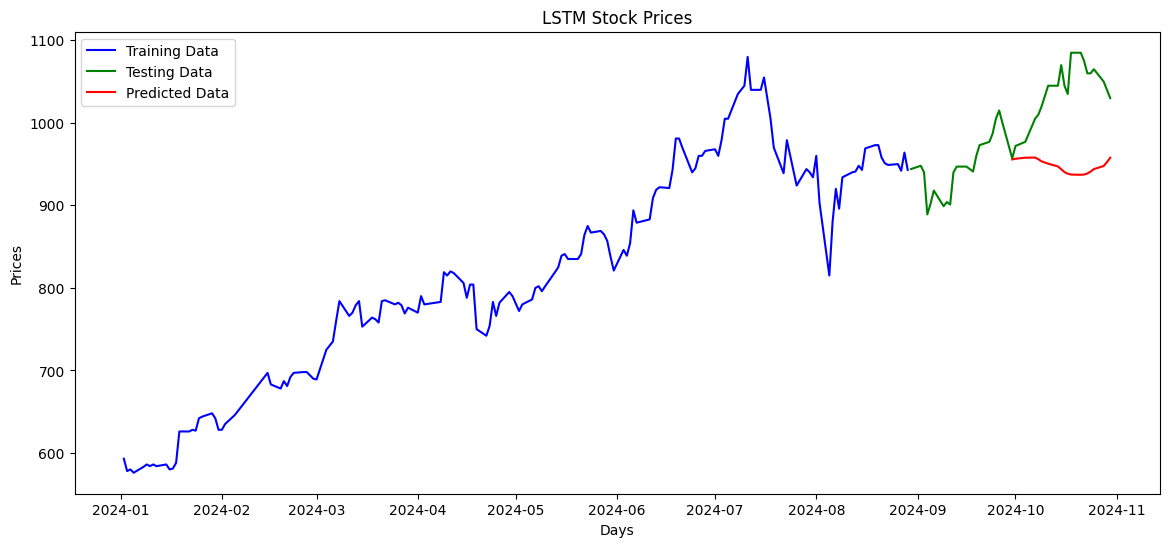

In [8]:
# 繪製圖表
plt.figure(figsize=(14, 6))
plt.plot(data.index[:train_size], scaler.inverse_transform(data_scaled[:train_size]), color="blue", label="Training Data")
plt.plot(data.index[train_size:], scaler.inverse_transform(data_scaled[train_size:]), color="green", label="Testing Data")
plt.plot(test_dates, test_predict, color="red", label="Predicted Data")
plt.title("LSTM Stock Prices")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.legend()
plt.show()

# 作業2：使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。輸出結果範例：輸入20天收盤價，預測隔一天收盤價

## 載入資料並預處理

In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 設置隨機種子以確保結果可重現
np.random.seed(0)
tf.random.set_seed(0)

# 使用 yfinance 獲取台積電 (2330.TW) 股價資料
ticker = "2330.TW"
start_date = "2024-01-01"
end_date = "2024-10-31"
data = yf.download(ticker, start=start_date, end=end_date)

# 使用收盤價進行分析
close_prices = data[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

[*********************100%***********************]  1 of 1 completed


## 建立資料集與訓練/測試集

In [19]:
# 設置自訂窗口大小
window_size = 20

# 構建訓練和測試數據集
def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(y)

# 訓練集和測試集劃分
train_size = int(len(close_prices_scaled) * 0.8)
train_data = close_prices_scaled[:train_size]
test_data = close_prices_scaled[train_size:]

X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# 為了符合 LSTM 的輸入，重塑輸入為 (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## 定義 Transformer 編碼器

In [20]:
# Transformer 編碼器模組
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

##  建立 Transformer 模型

In [21]:
# 構建 Transformer 模型
def build_transformer_model(head_size, num_heads, ff_dim, num_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=(window_size, 1))
    x = inputs
    for _ in range(num_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

# 初始化並編譯模型
model = build_transformer_model(head_size=128, num_heads=4, ff_dim=128, num_blocks=4, mlp_units=[128], dropout=0.1, mlp_dropout=0.1)
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 20, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 20, 1)          │              2 │ input_layer_3[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 20, 1)          │          3,585 │ layer_normalization_9… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 20, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 20, 1)          │              0 │ dropout_16[0][0],      │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 20, 1)          │              2 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 20, 128)        │            256 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 20, 128)        │              0 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 20, 1)          │            129 │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 20, 1)          │              0 │ conv1d_9[0][0],        │
│                           │                        │                │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_11    │ (None, 20, 1)          │              2 │ add_10[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_6    │ (None, 20, 1)          │          3,585 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 20, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 20, 1)          │              0 │ dropout_19[0][0],      │
│                           │                        │                │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 20, 1)          │              2 │ add_11[0][0]           │
│ (LayerNormalization) 

 Total params: 16,281 (63.60 KB)

 Trainable params: 16,281 (63.60 KB)

 Non-trainable params: 0 (0.00 B)

## 訓練模型

In [22]:
# 訓練模型
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - loss: 0.3084 - val_loss: 0.4852
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2317 - val_loss: 0.3635
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1269 - val_loss: 0.1405
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0743 - val_loss: 0.0391
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0988 - val_loss: 0.0611
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0856 - val_loss: 0.1250
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0714 - val_loss: 0.1713
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0804 - val_loss: 0.1687
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0688 - val_loss: 0.1355
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0687 - val_loss: 0.0994
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0690 - val_loss: 0.0849
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0662 - val_loss: 

## 評估模型並進行預測

In [23]:
# 評估模型
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Test Set:", mse)

# 預測股價並反轉標準化
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# 將測試資料的預測結果與實際結果整理成 DataFrame
test_data_unscaled = scaler.inverse_transform(test_data[window_size:])
test_predict = pd.DataFrame({"Actual": test_data_unscaled.flatten(), "Predicted": y_pred.flatten()}, index=data.index[train_size + window_size:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2458
Mean Squared Error on Test Set: 0.24576322734355927
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


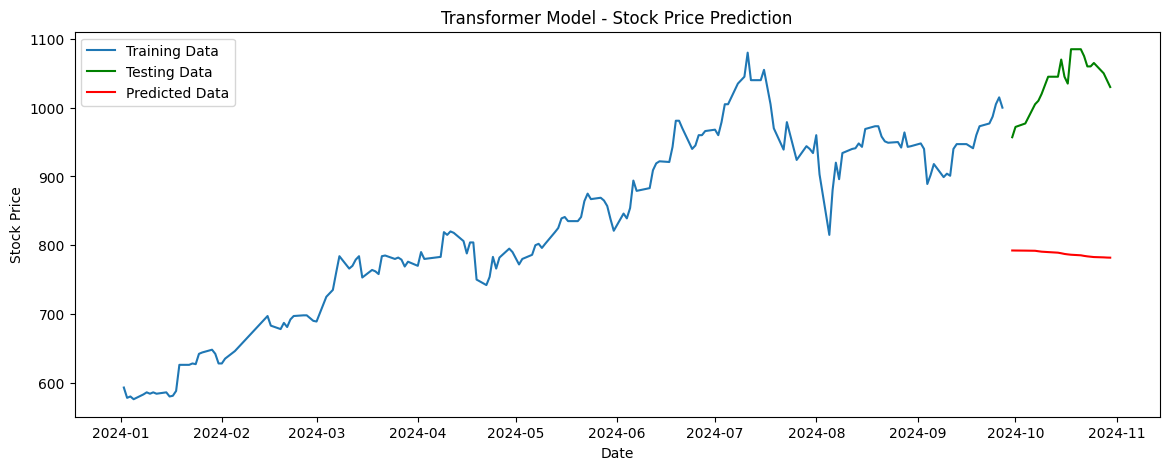

In [24]:
# 繪製結果
plt.figure(figsize=(14, 5))
plt.plot(close_prices.index[:train_size + window_size], close_prices["Close"][:train_size + window_size], label="Training Data")
plt.plot(close_prices.index[train_size + window_size:], close_prices["Close"][train_size + window_size:], label="Testing Data", color="green")
plt.plot(test_predict.index, test_predict["Predicted"], label="Predicted Data", color="red")
plt.title("Transformer Model - Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()